Saving Sherlock.txt to Sherlock (2).txt
Using device: cpu
Vocabulary Size: 8040
Variables saved to variables.pkl
Epoch [1/10], Loss: 6.9704
Epoch [2/10], Loss: 6.1676
Epoch [3/10], Loss: 5.7087
Epoch [4/10], Loss: 5.1379
Epoch [5/10], Loss: 4.4164
Epoch [6/10], Loss: 3.7945
Epoch [7/10], Loss: 3.4123
Epoch [8/10], Loss: 3.1696
Epoch [9/10], Loss: 2.9930
Epoch [10/10], Loss: 2.8452
Training completed.
Model weights saved as model.pth


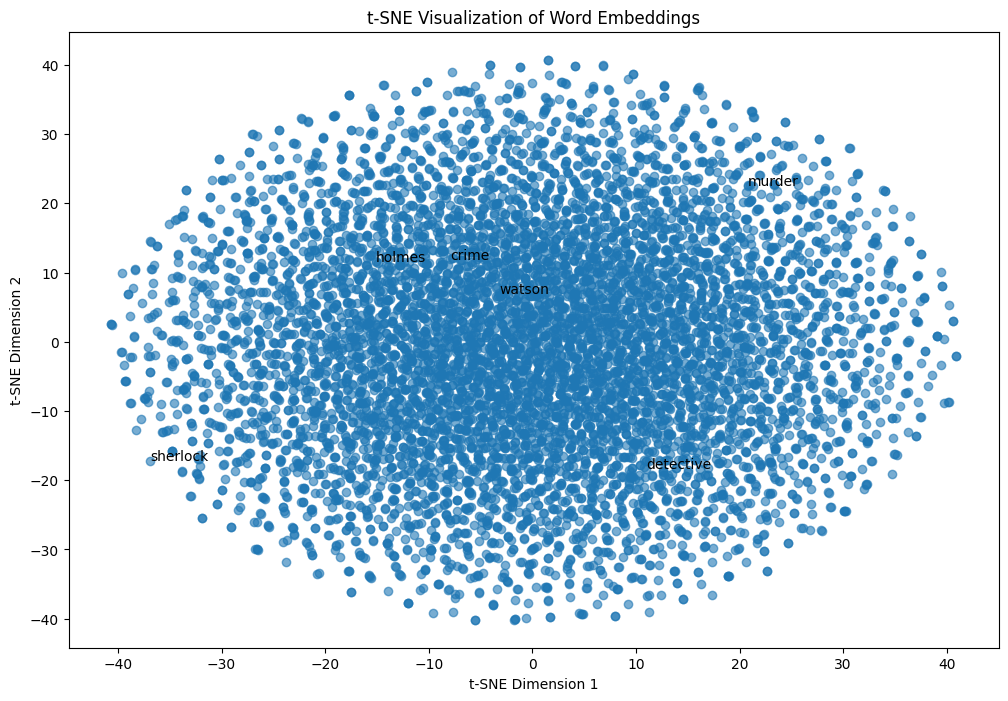

In [9]:
# Step 1: Install Required Libraries
!pip install torch torchvision streamlit

# Step 2: Import Necessary Libraries
import torch
from torch import nn
from torch.utils.data import DataLoader, TensorDataset
import re
import pickle
import torch.nn.functional as F
from sklearn.manifold import TSNE
import pandas as pd
import matplotlib.pyplot as plt
from collections import Counter

# Step 3: Upload Your Text File
from google.colab import files
uploaded = files.upload()  # Choose your Sherlock.txt file when prompted

# Step 4: Device Configuration
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

# Step 5: Preprocess the Dataset
with open("Sherlock.txt", "r", encoding="utf-8") as f:
    text = f.read()
text = re.sub(r'[^a-zA-Z0-9\s]', ' ', text).lower()
words = [word for word in text.split() if len(word) > 2]

# Step 6: Vocabulary Creation
vocab = sorted(set(words))
stoi = {word: i + 1 for i, word in enumerate(vocab)}
stoi['<PAD>'] = 0
itos = {i: word for word, i in stoi.items()}
vocab_size = len(stoi)

print(f"Vocabulary Size: {vocab_size}")

# Step 7: Save Variables
def save_variables(block_size, random_seed):
    variables = {
        'vocab_size': vocab_size,
        'stoi': stoi,
        'itos': itos,
        'block_size': block_size,
        'random_seed': random_seed
    }
    with open('variables.pkl', 'wb') as f:
        pickle.dump(variables, f)
    print("Variables saved to variables.pkl")

# Step 8: Define the Model
class NextWordPredictor(nn.Module):
    def __init__(self, block_size, vocab_size, emb_dim, hidden_size, activation):
        super().__init__()
        self.emb = nn.Embedding(vocab_size, emb_dim)
        self.lin1 = nn.Linear(block_size * emb_dim, hidden_size)
        self.activation = activation
        self.lin2 = nn.Linear(hidden_size, vocab_size)

    def forward(self, x):
        x = self.emb(x)  # shape: (batch_size, block_size, emb_dim)
        x = x.view(x.size(0), -1)  # flatten to shape: (batch_size, block_size * emb_dim)
        x = self.activation(self.lin1(x))  # shape: (batch_size, hidden_size)
        return self.lin2(x)  # shape: (batch_size, vocab_size)


# Step 9: Load Dataset
def load_dataset(block_size):
    with open("Sherlock.txt", "r", encoding="utf-8") as f:
        text = f.read()
    text = re.sub(r'[^a-zA-Z0-9\s]', ' ', text).lower()
    words = [word for word in text.split() if len(word) > 2]

    X, Y = [], []
    for i in range(len(words) - block_size):
        context = words[i:i + block_size]
        target = words[i + block_size]
        X.append([stoi.get(w, 0) for w in context])
        Y.append(stoi.get(target, 0))

    X = torch.tensor(X, dtype=torch.long)
    Y = torch.tensor(Y, dtype=torch.long)
    return DataLoader(TensorDataset(X, Y), batch_size=128, shuffle=True)

# Step 10: Set Hyperparameters
block_size = 5  # Number of words in the context window
emb_dim = 64    # Embedding dimension
hidden_size = 128  # Number of units in the hidden layer
num_epochs = 10  # Number of training epochs
learning_rate = 0.001  # Learning rate
random_seed = 42  # Seed for reproducibility

# Step 11: Save Variables for Reproducibility
save_variables(block_size, random_seed)

# Step 12: Initialize the Model
model = NextWordPredictor(block_size, vocab_size, emb_dim, hidden_size, activation=F.relu).to(device)

# Step 13: Define Loss Function and Optimizer
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

# Step 14: Load the Dataset
train_loader = load_dataset(block_size)

# Step 15: Training Loop
for epoch in range(num_epochs):
    model.train()  # Set the model to training mode
    total_loss = 0

    for X_batch, Y_batch in train_loader:
        X_batch, Y_batch = X_batch.to(device), Y_batch.to(device)

        # Forward pass
        outputs = model(X_batch)
        loss = criterion(outputs, Y_batch)

        # Backward pass and optimization
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        total_loss += loss.item()

    avg_loss = total_loss / len(train_loader)
    print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {avg_loss:.4f}')

print("Training completed.")

# Step 16: Save the Model Weights
torch.save(model.state_dict(), 'model.pth')
print("Model weights saved as model.pth")

# Step 17: t-SNE Visualization
embeddings = model.emb.weight.data.cpu().numpy()

# Apply t-SNE for dimensionality reduction
tsne = TSNE(n_components=2, random_state=42)
reduced_embeddings = tsne.fit_transform(embeddings)

# Create a scatter plot for the reduced embeddings
plt.figure(figsize=(12, 8))
plt.scatter(reduced_embeddings[:, 0], reduced_embeddings[:, 1], alpha=0.6)

# Annotate a subset of points for visualization clarity
words_to_annotate = ['sherlock', 'holmes', 'watson', 'detective', 'crime', 'murder']
for word in words_to_annotate:
    if word in stoi:
        idx = stoi[word]
        plt.annotate(word, (reduced_embeddings[idx, 0], reduced_embeddings[idx, 1]))

plt.title("t-SNE Visualization of Word Embeddings")
plt.xlabel("t-SNE Dimension 1")
plt.ylabel("t-SNE Dimension 2")
plt.show()



In [18]:
# Step 1: Install Required Libraries
!pip install torch torchvision

# Step 2: Import Necessary Libraries
import torch
from torch import nn
import pickle
import torch.nn.functional as F

# Step 3: Load the Trained Model Weights
class NextWordPredictor(nn.Module):
    def __init__(self, block_size, vocab_size, emb_dim, hidden_size, activation):
        super().__init__()
        self.emb = nn.Embedding(vocab_size, emb_dim)
        self.lin1 = nn.Linear(block_size * emb_dim, hidden_size)
        self.activation = activation
        self.lin2 = nn.Linear(hidden_size, vocab_size)

    def forward(self, x):
        x = self.emb(x)  # shape: (batch_size, block_size, emb_dim)
        x = x.view(x.size(0), -1)  # flatten to shape: (batch_size, block_size * emb_dim)
        x = self.activation(self.lin1(x))  # shape: (batch_size, hidden_size)
        return self.lin2(x)  # shape: (batch_size, vocab_size)

# Step 4: Device Configuration
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

# Load variables
with open('variables.pkl', 'rb') as f:
    variables = pickle.load(f)

vocab_size = variables['vocab_size']
block_size = variables['block_size']

# Step 5: Initialize the Model
emb_dim = 64    # Embedding dimension
hidden_size = 128  # Number of units in the hidden layer
model = NextWordPredictor(block_size, vocab_size, emb_dim, hidden_size, activation=F.relu).to(device)
model.load_state_dict(torch.load('model.pth'))
model.eval()  # Set the model to evaluation mode

# Step 6: Prediction Function
def predict_next_word(model, input_words):
    with torch.no_grad():
        # Convert input words to indices
        input_indices = [variables['stoi'].get(word, 0) for word in input_words.split()]

        # Ensure the input length matches block_size
        if len(input_indices) > block_size:
            input_indices = input_indices[-block_size:]  # take the last block_size elements
        elif len(input_indices) < block_size:
            input_indices = [0] * (block_size - len(input_indices)) + input_indices  # pad with zeros

        input_tensor = torch.tensor(input_indices, dtype=torch.long).unsqueeze(0).to(device)
        outputs = model(input_tensor)

        # Get predicted word indices
        predicted_index = torch.argmax(outputs, dim=1).item()  # Get the index of the highest scoring word

        # Convert index to word
        predicted_word = variables['itos'][predicted_index]
    return predicted_word

# Step 7: Generate Text Function
def generate_text(model, input_text, max_words):
    generated_text = input_text
    for _ in range(max_words):
        predicted_word = predict_next_word(model, ' '.join(generated_text.split()[-block_size:]))  # Use the last `block_size` words
        generated_text += ' ' + predicted_word
    return generated_text

# Example usage of the generate_text function
input_text = "that boy is mine;"
max_words = 1000  # Number of words to generate
generated_text = generate_text(model, input_text, max_words)
print(f"Generated text: {generated_text}")


Using device: cpu


<ipython-input-18-2d0f8f9762e0>:40: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load('model.pth'))


Generated text: that boy is mine; was not surprised upon the other side the panel and drove the advice heart coloured and the great train the waterloo and writhed down the shoulder order stretched the door wrung hope that was true the intimate great conjecture into the inner knock and you think that the world plays have heard the whole pool matters was the door locked the house and the rest the walls the missing individual the work and the project gutenberg trademark swiftly and order closely the way the wood the ejaculation track and has not been ascertained his deep tide his armchair and discretion his hands delicate the first you have frequently the village the son was the door and the carriage the altar the street and the police whom reasoning the door you have been fortunate enough gain bowed the presence and the carriage the ceiling the most man met him the matter and the moral remarks the new rooms that the door was eventually and the whole room trademark from the conclusion hea

In [19]:
!pip install streamlit
!pip install pyngrok


In [ ]:
%%writefile app.py
import streamlit as st
import torch
import pickle
from torch import nn
import torch.nn.functional as F

# Load the trained model weights
class NextWordPredictor(nn.Module):
    def __init__(self, block_size, vocab_size, emb_dim, hidden_size, activation):
        super().__init__()
        self.emb = nn.Embedding(vocab_size, emb_dim)
        self.lin1 = nn.Linear(block_size * emb_dim, hidden_size)
        self.activation = activation
        self.lin2 = nn.Linear(hidden_size, vocab_size)

    def forward(self, x):
        x = self.emb(x)
        x = x.view(x.size(0), -1)
        return self.lin2(self.activation(self.lin1(x)))

# Load variables
with open('variables.pkl', 'rb') as f:
    variables = pickle.load(f)

# Load the model
vocab_size = variables['vocab_size']
block_size = variables['block_size']
emb_dim = 64
hidden_size = 128
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model = NextWordPredictor(block_size, vocab_size, emb_dim, hidden_size, activation=F.relu).to(device)
model.load_state_dict(torch.load('model.pth'))
model.eval()

# Define the prediction function
def predict_next_word(model, input_words):
    with torch.no_grad():
        input_indices = [variables['stoi'].get(word, 0) for word in input_words.split()]
        if len(input_indices) > block_size:
            input_indices = input_indices[-block_size:]
        elif len(input_indices) < block_size:
            input_indices = [0] * (block_size - len(input_indices)) + input_indices

        input_tensor = torch.tensor(input_indices, dtype=torch.long).unsqueeze(0).to(device)
        outputs = model(input_tensor)
        predicted_index = torch.argmax(outputs, dim=1).item()
        predicted_word = variables['itos'][predicted_index]
    return predicted_word

# Streamlit app layout
st.title("Next Word Predictor")
input_text = st.text_input("Enter text:")
max_words = st.number_input("Number of words to generate:", min_value=1, max_value=20, value=5)

if st.button("Generate"):
    generated_text = input_text
    for _ in range(max_words):
        predicted_word = predict_next_word(model, ' '.join(generated_text.split()[-block_size:]))
        generated_text += ' ' + predicted_word
    st.write(f"Generated text: {generated_text}")


In [26]:
!npm install -g localtunnel



added 22 packages, and audited 23 packages in 2s

3 packages are looking for funding
  run `npm fund` for details

1 moderate severity vulnerability

To address all issues (including breaking changes), run:
  npm audit fix --force

Run `npm audit` for details.


In [ ]:
!streamlit run app.py & npx ngrok http 8501






  You can now view your Streamlit app in your browser.

  Local URL: http://localhost:8501
  Network URL: http://172.28.0.12:8501
  External URL: http://34.125.93.19:8501



In [22]:
pip install streamlit torch torchvision


In [28]:
from pyngrok import ngrok
import os

# Set up ngrok to tunnel to the streamlit port
public_url = ngrok.connect(port='8501')
print(f"Access your Streamlit app at: {public_url}")

# Run the Streamlit app
os.system("streamlit run app.py &")


ERROR:pyngrok.process.ngrok:t=2024-10-28T14:00:10+0000 lvl=eror msg="failed to reconnect session" obj=tunnels.session err="authentication failed: Usage of ngrok requires a verified account and authtoken.\n\nSign up for an account: https://dashboard.ngrok.com/signup\nInstall your authtoken: https://dashboard.ngrok.com/get-started/your-authtoken\r\n\r\nERR_NGROK_4018\r\n"
ERROR:pyngrok.process.ngrok:t=2024-10-28T14:00:10+0000 lvl=eror msg="session closing" obj=tunnels.session err="authentication failed: Usage of ngrok requires a verified account and authtoken.\n\nSign up for an account: https://dashboard.ngrok.com/signup\nInstall your authtoken: https://dashboard.ngrok.com/get-started/your-authtoken\r\n\r\nERR_NGROK_4018\r\n"
ERROR:pyngrok.process.ngrok:t=2024-10-28T14:00:10+0000 lvl=eror msg="terminating with error" obj=app err="authentication failed: Usage of ngrok requires a verified account and authtoken.\n\nSign up for an account: https://dashboard.ngrok.com/signup\nInstall your aut

PyngrokNgrokError: The ngrok process errored on start: authentication failed: Usage of ngrok requires a verified account and authtoken.\n\nSign up for an account: https://dashboard.ngrok.com/signup\nInstall your authtoken: https://dashboard.ngrok.com/get-started/your-authtoken\r\n\r\nERR_NGROK_4018\r\n.